# Main

___
## Imports

In [45]:
import numpy as np
import os
from collections import Counter


from utils.load import download_flickr, download_glove, load_data, load_split_dataset
from utils.explore import (
    get_descriptive_statistics,
    explore_dataset,
    visualize_image,
    get_captions,
)
from utils.split import split_and_save_data
from utils.preprocessing import get_vocabulary, resize_image_dictionary, pad_images

from keras.applications.inception_v3 import (
    InceptionV3,
    preprocess_input,
    decode_predictions,
)
from keras.models import Model
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from tensorflow.keras.layers import Flatten, Input, Dropout, Dense, Embedding, LSTM, MaxPooling2D, Conv2D, add


___
## Global Variables

In [2]:
image_folder = "data/Images"
image_folder_homogeneous = "data/Images_homogeneous"
captions_file = "data/captions.txt"
split_data = "data/split_dataset"

___
## Downloading the Dataset

If not already done

In [3]:
if not os.path.exists("data/Image"):
    download_flickr()

___
## Exploring the Dataset

Valid if the dataset has already been loaded into your `data` folder.

Number of images: 8091
Max width: 500, Min width: 164, Mean width: 457.87220368310466
Max height: 500, Min height: 127, Mean height: 397.25188481028306


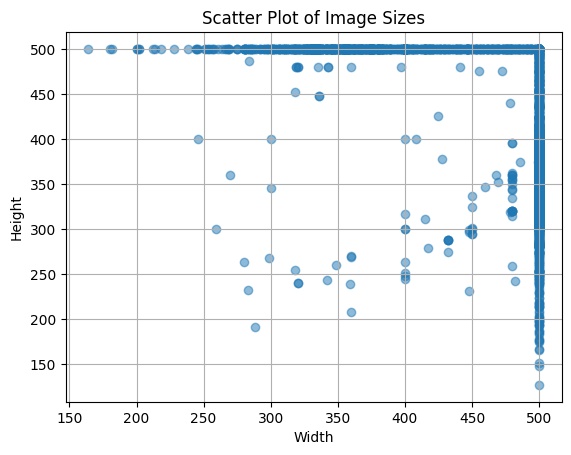

In [4]:
get_descriptive_statistics(image_folder)

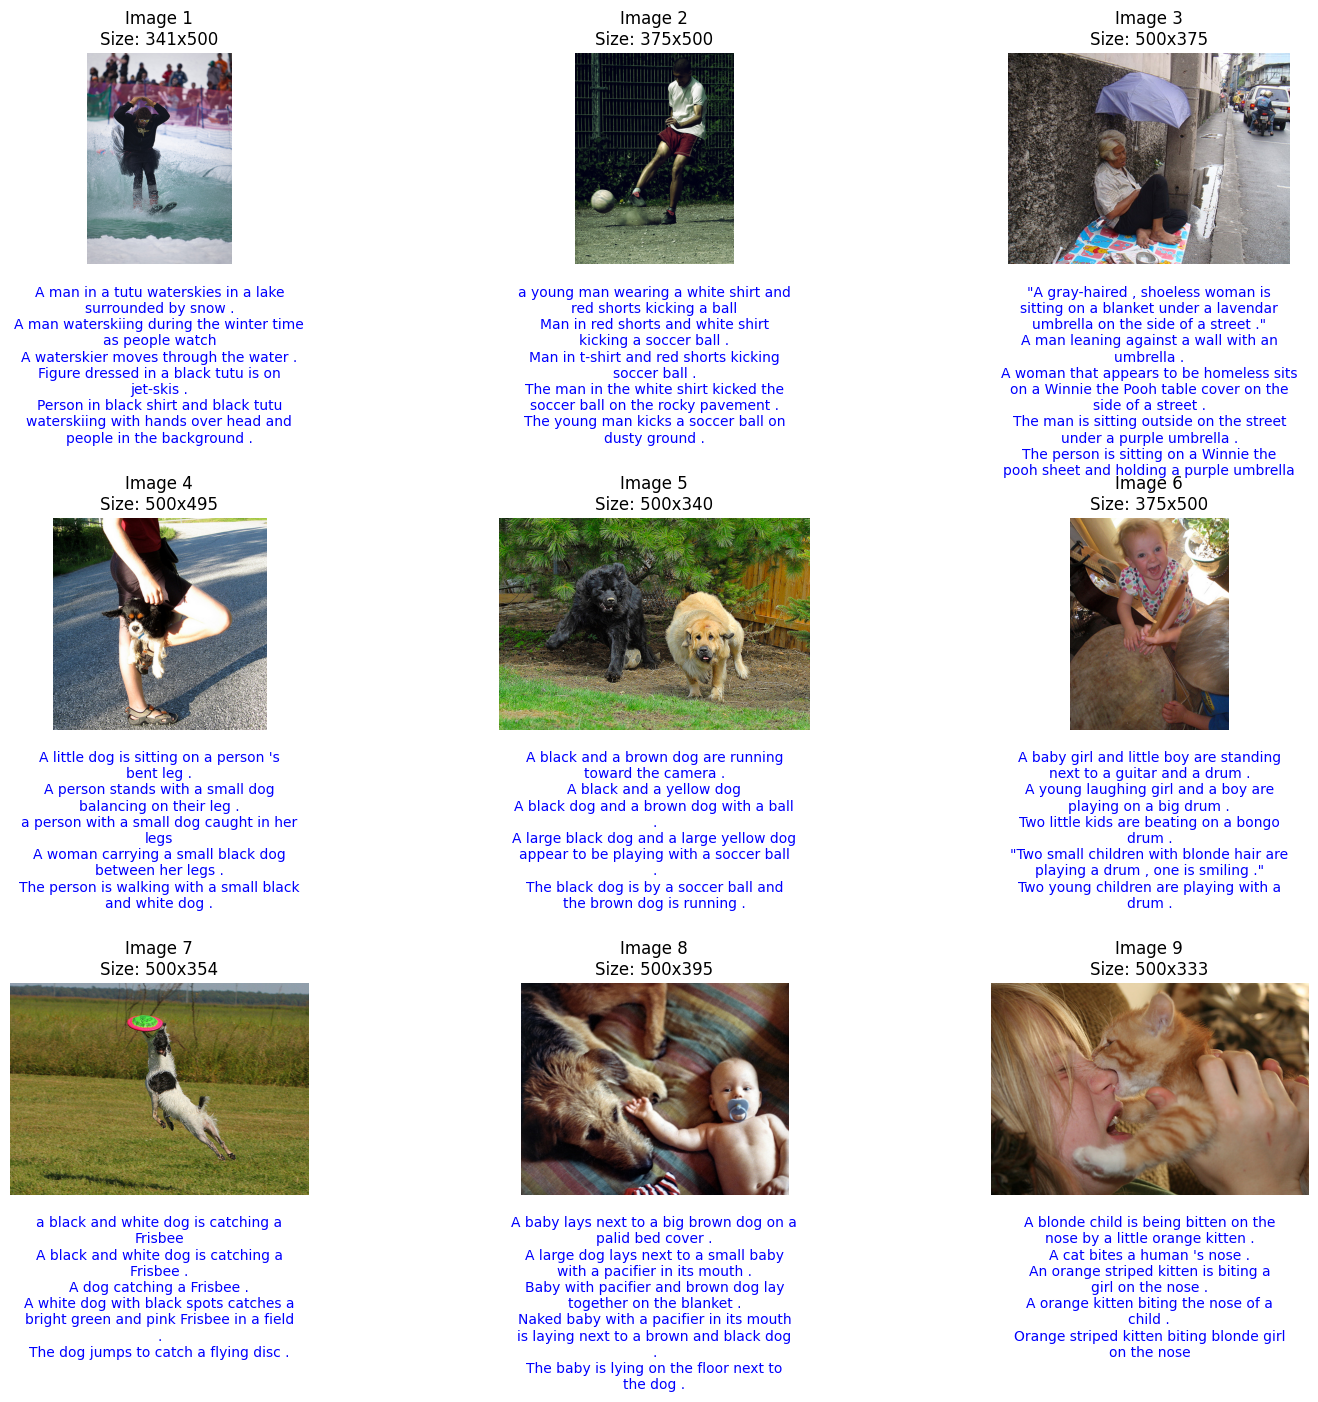

In [5]:
explore_dataset(image_folder, captions_file)

___
## Loading the Data

In [6]:
# adding padding so that all images have the same dimensions
if not os.path.exists(image_folder_homogeneous):
    pad_images(image_folder, image_folder_homogeneous, target_size=(500, 500))

In [7]:
image_arrays, image_captions = load_data(image_folder_homogeneous, captions_file)

In [8]:
print(type(image_arrays), type(image_captions))

<class 'dict'> <class 'dict'>


### Cleaning the Captions

We exploring the `data/captions.txt` file, we notice that the captions seem to end with a `.`, so let's just remove this to have cleaner captions.

In [9]:
image_captions = {
    img_name: [cap.replace('.', '').strip().lower() for cap in captions]
    for img_name, captions in image_captions.items()
}

### Creating the Vocabulary

The vocabulary contains all the unique words present in the captions.

In [10]:
vocabulary = get_vocabulary(image_captions)

___
## Splitting the Dataset

In [11]:
train_data, val_data, test_data, train_captions, val_captions, test_captions = split_and_save_data(image_arrays, image_captions, save_folderpath=split_data)

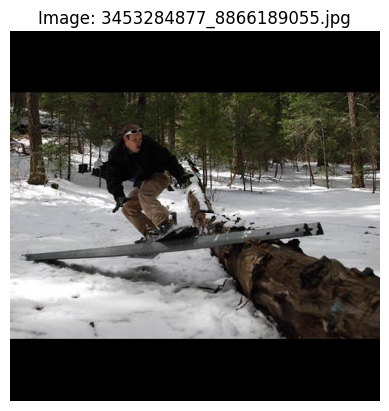

['a guy is grinding a rail over a tree on his snowboard', 'a man snowboarding making a jump off a steel guardrail', 'a snowboarder grinding up a homemade ramp', 'a snowboarder is riding his board on ramp made from a piece of metal and a log', 'the man is skateboarding over a log in the snow']


In [12]:
i = 129
visualize_image(train_data, i)
print(
    get_captions(train_captions, i)
)

___
## Extracting a Feature Vector from each image

We can extract the main features of an image with a pre-trained model, which has been trained in a large dataset. This way we can get from each image a vector containing the main characteristics of this image. We will use the **InceptionV3** model.

In [13]:
def get_ith_value(dict, i):
    return list(dict.values())[i]

In [14]:
base_model = InceptionV3(weights="imagenet")
model = Model(base_model.input, base_model.layers[-2].output)


def encode_images(
    img_dict: dict, model: Model = model, batch_size: int = 32
) -> dict[str, np.ndarray]:
    print("resizing the images...")
    resized_images = resize_image_dictionary(img_dict, (299, 299))
    feature_vectors = {}
    print("extracting the feature vectors...")
    img_names = list(resized_images.keys())
    img_arrays = list(resized_images.values())
    # preprocessing all images
    img_arrays = [preprocess_input(img_array) for img_array in img_arrays]

    for start_index in range(0, len(img_names), batch_size):
        end_index = min(start_index + batch_size, len(img_names))
        batch_images = img_arrays[start_index:end_index]
        batch_names = img_names[start_index:end_index]
        # predicting the feature vectors for the batch
        batch_vectors = model.predict(np.array(batch_images))
        # reshaping and storing the feature vectors
        for i, img_name in enumerate(batch_names):
            vec = np.reshape(batch_vectors[i], (batch_vectors.shape[1]))
            feature_vectors[img_name] = vec
        
    return feature_vectors


fea_vec_train = encode_images(train_data)

print(fea_vec_train)
print(len(list(train_data.values())), len(fea_vec_train.values()))

resizing the images...
extracting the feature vectors...
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━

___
## Tokenization of the Vocabulary

We need to tokenize our vocabulary to make it understandable for a neural network.

In [15]:
min_apparitions = 10  # defining a threshold of number of apparitions in the text.

text = " ".join(
    [" ".join(train_captions[img_name]) for img_name in list(train_captions.keys())]
)
# doit-on mettre les 3 dict captions ou non ?

words = text.split(" ")

# this returns a dictionary containing the words and the number of their occurrences in the text
words_count = Counter(words)

# keeping just the important words
important_words = [
    word for word, n_occ in words_count.items() if n_occ >= min_apparitions
]

# mapping the words to integers
int_to_word = {i: word for i, word in enumerate(important_words)}
word_to_int = {word: i for i, word in enumerate(important_words)}

vocabulary_size = len(list(int_to_word.keys()))
print(vocabulary_size)

# find the maximum length of a description in a dataset
max_length = max(
    [
        max([len(caption.split(" ")) for caption in captions])
        for captions in list(train_captions.values())
    ]
)
print(max_length)

1749
37


___
## Vector Embeddings

In [16]:
if not os.path.exists("data/glove"):
    download_glove()

In [22]:
# resizing for computation
target_size = (128, 128)
train_data = resize_image_dictionary(train_data, target_size)
val_data = resize_image_dictionary(val_data, target_size)
test_data = resize_image_dictionary(test_data, target_size)

In [33]:
X1, X2, y = [], [], []

for img_name, caps in train_captions.items():
    img_array = train_data[img_name]

    for cap in caps:
        sequence = [word_to_int[word] for word in cap.split(" ") if word in word_to_int]

        for i in range(1, len(sequence)):
            input_sequence = sequence[:i]
            output_sequence = sequence[i]

            input_sequence = pad_sequences([input_sequence], maxlen=max_length)[0]
            output_sequence = to_categorical(
                [output_sequence], num_classes=vocabulary_size
            )[0]

            X1.append(img_array)
            X2.append(input_sequence)
            y.append(output_sequence)

X2 = np.array(X2)
X1 = np.array(X1)
y = np.array(y)


# load glove vectors for embedding layer
embeddings_index = {}
glove_path = "data/glove/glove.6B.200d.txt"
glove = open(glove_path, "r", encoding="utf-8").read()
for line in glove.split("\n"):
    values = line.split(" ")
    word = values[0]
    if word != '':
        indices = np.asarray(values[1:], dtype="float32")
        embeddings_index[word] = indices



In [ ]:
embedding_dim = 200
embedding_matrix = np.zeros((vocabulary_size, embedding_dim))
print(embedding_matrix.shape)
for word, i in word_to_int.items():
    if word != '' and word in embeddings_index:
        embedding_vector = embeddings_index[word]
        if embedding_vector is not None and embedding_vector.shape != (0,):
            embedding_matrix[i] = embedding_vector

embedding_matrix.shape

(1749, 200)


(1749, 200)

___
## Defining the Model

In [50]:
input_1 = Input(shape=(target_size[0], target_size[1], 3))

# Add convolutional layers for feature extraction
conv_1 = Conv2D(64, (3, 3), activation='relu')(input_1)
pool_1 = MaxPooling2D((2, 2))(conv_1)
conv_2 = Conv2D(128, (3, 3), activation='relu')(pool_1)
pool_2 = MaxPooling2D((2, 2))(conv_2)
conv_3 = Conv2D(256, (3, 3), activation='relu')(pool_2)
pool_3 = MaxPooling2D((2, 2))(conv_3)
flattened_features = Flatten()(pool_3)

# features_1 = Dropout(0.2)(input_1)
features_1 = Dropout(0.2)(flattened_features)
features_2 = Dense(256, activation="relu")(features_1)

input_2 = Input(shape=(max_length,))
sequence_1 = Embedding(vocabulary_size, embedding_dim, mask_zero=True)(input_2)
sequence_2 = Dropout(0.2)(sequence_1)
sequence_3 = LSTM(256)(sequence_2)

decoder_1 = add([features_2, sequence_3])
decoder_2 = Dense(256, activation="relu")(decoder_1)

flattened_output = Flatten()(decoder_2)
outputs = Dense(vocabulary_size, activation="softmax")(flattened_output)
model = Model(inputs=[input_1, input_2], outputs=outputs)

model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_15      │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_103 (Conv2D) │ (None, 126, 126,  │      1,792 │ input_layer_15[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_13    │ (None, 63, 63,    │          0 │ conv2d_103[0][0]  │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_104 (Conv2D) │ (None, 61, 61,    │     73,856 │ max_pooling2d_13… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_14    │ (None, 30, 30,    │          0 │ conv2d_104[0][0]  │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_105 (Conv2D) │ (None, 28, 28,    │    295,168 │ max_pooling2d_14… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_15    │ (None, 14, 14,    │          0 │ conv2d_105[0][0]  │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_16      │ (None, 37)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_7 (Flatten) │ (None, 50176)     │          0 │ max_pooling2d_15… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_7         │ (None, 37, 200)   │    349,800 │ input_layer_16[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_14          │ (None, 50176)     │          0 │ flatten_7[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_15          │ (None, 37, 200)   │          0 │ embedding_7[0][0] │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_7         │ (None, 37)        │          0 │ input_layer_16[0… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_21 (Dense)    │ (None, 256)       │ 12,845,312 │ dropout_14[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_7 (LSTM)       │ (None, 256)       │    467,968 │ dropout_15[0][0], │
│                     │                   │            │ not_equal_7[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_7 (Add)         │ (None, 256)       │          0 │ dense_21[0][0],   │
│                     │                   │            │ lstm_7[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_22 (Dense)    │ (None, 256)       │     65,792 │ add_7[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_8 (Flatten) │ (None, 256)       │          0 │ dense_22[0][0]  

 Total params: 14,549,181 (55.50 MB)

 Trainable params: 14,549,181 (55.50 MB)

 Non-trainable params: 0 (0.00 B)

___
## Training the Model

In [ ]:
for layer in model.layers:
    if isinstance(layer, Embedding):
        layer.set_weights([embedding_matrix])
        layer.trainable = False
model.compile(loss="categorical_crossentropy", optimizer="adam")
model.fit([X1, X2], y, epochs=50, batch_size=256)

Epoch 1/50
 175/1192 ━━━━━━━━━━━━━━━━━━━━ 3:00:55 11s/step - loss: 9.3913

___
## Predicting the output

In [ ]:
def generate_caption(image_array: np.ndarray) -> str:
    start = "startseq"
    for i in range(max_length):
        sequence = [word_to_int[word] for word in start.split() if word in word_to_int]
        sequence = pad_sequences([sequence], maxlen=max_length)

        y_pred = model.predict([image_array, sequence])
        y_pred = np.argmax(y_pred)

        word = int_to_word[y_pred]
        start += ' ' + word
        if word == "endseq":
            break

    final = start.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

print("please test the model!")